### 1. Importing all the libraries, checking for Tensorflow 2 and setting the seeds

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import random as python_random

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  
#tf.random.set_seed(seed)

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

2.4.1


### 2. Helper functions for the visualisation

In [ ]:
# Plotting the loss functions used in this notebook
# we plot the loss we want to optimise on th eleft (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

### 3. Mounting your Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

#!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 4. Loading the data

In [ ]:
# load train and test data
(x_train_all, r_train_all_class), (x_test, r_test_class) = mnist.load_data()
x_train_all = x_train_all.reshape(x_train_all.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
x_train_all = x_train_all.astype('float32')
x_test = x_test.astype('float32')
x_train_all /= 255
x_test /= 255

print(x_train_all.shape[0], ' original train samples')
print(x_test.shape[0], ' original test samples')

# This data set contains a train set and test set
# we still need to split off a validation set

# Number of test samples
N_test = x_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = x_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state to make sure you get the same split each time
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size = N_val, random_state=0)

# For initial explorations, it is often useful to 
# try out some things first on a smaller data set
# in comment below is the code for using all training data
# in this case, we select 10000 samples for training
# don't forget to use all training examples for your final model
# by replacing the line below by the commented one beneath it

N_train = 50000

x_train = x_train[:N_train,:]
r_train_class = r_train_class[:N_train]

print("Using ",x_train.shape[0]," train samples, ", x_val.shape[0], " validation samples and ",x_test.shape[0]," test samples")
print("Each sample has ",x_train.shape[1]," features")

60000  original train samples
10000  original test samples
Using  50000  train samples,  10000  validation samples and  10000  test samples
Each sample has  784  features



###5. Visualisation of a few training samples


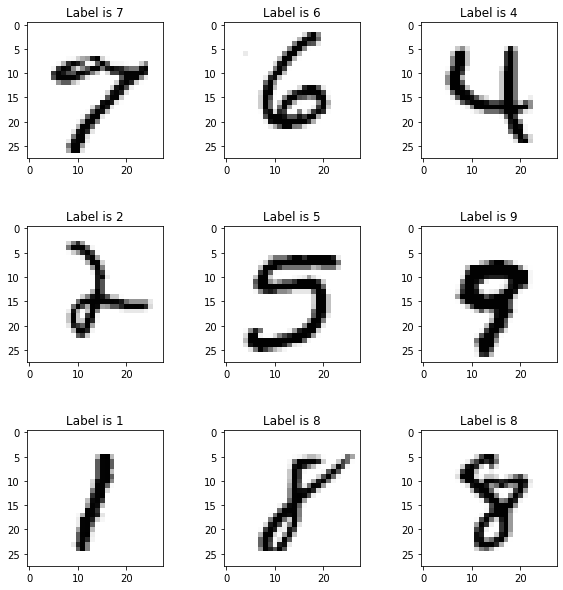

In [ ]:
# The features in this data set are the pixels of a 28x28 pixel image
# You can visualise an individual image as follows
# (here for the first 9 images in the training set)

f = plt.figure(figsize=(10,10));
for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is " + str(r_train_class[idx]))
    plt.imshow(np.reshape(x_train[idx,:],(28,28)), cmap='Greys', interpolation='None')

###6. Convert class vectors to binary class matrices

In [ ]:
r_train_all = keras.utils.to_categorical(r_train_all_class)
r_train = keras.utils.to_categorical(r_train_class)
r_val = keras.utils.to_categorical(r_val_class)
r_test = keras.utils.to_categorical(r_test_class)

# look at the new labels for the first sample
print(r_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


###7. Create initial model without regularization

In [ ]:
num_classes = 10

def initial_model(): 
    # create linear model
    model = Sequential()
    # we start with a first fully connected layer
    model.add(Dense(1024, activation='relu', input_shape=(784,), kernel_initializer='he_uniform'))
    # Add a second fully connected layer
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00025), # set to default learning rate here
                  metrics=['accuracy']) # save accuracy in addition to cross entropy error
    return model

###8. Training and checking the power of our initial model

In [ ]:
# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 512
epochs = 30

history_1 = model_1.fit(x_train, r_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, r_val)
                    )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                5130      
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
98/98 [==============================] - 1s 7ms/step - loss: 0.9393 - accuracy: 0.7415 - val_loss: 0.2163 - val_accuracy: 0.9371
Epoch 2/30
98/98 [==============================] - 0s 5ms/step - loss: 0.2040 - accuracy: 0.9424 - val_loss: 0.1472 - val_accuracy: 0.9570
Epoch 3/30
98/98 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9

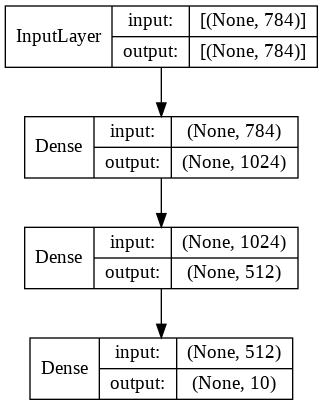

In [ ]:
keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=False)

Training set Accuracy: 1.0000
Training set Loss:0.000864

Validation set Accuracy: 0.9820
Validation set Loss:0.066470



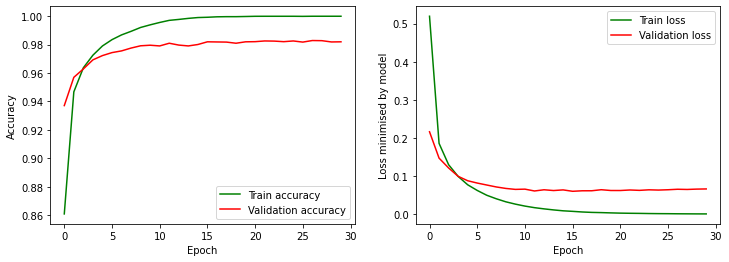

In [ ]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

###9. Adding regularisation to the initial model

In [ ]:
num_classes = 10

def initial_model():
    # create linear model
    model = Sequential()
    # we start with a first fully connected layer
    model.add(Dense(1024, activation='relu', input_shape=(784,), kernel_initializer='he_uniform',
              kernel_regularizer=regularizers.L1L2(l1= 1e-6, l2=1e-4), kernel_constraint=max_norm(0.5)))#l2 was 1e-4
    model.add(Dropout(0.6)) #was0.5
    # Add a second fully connected layer
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform',
              kernel_regularizer=regularizers.L1L2(l1= 1e-6, l2=1e-4), kernel_constraint=max_norm(1.))) #was 1e-4
    model.add(Dropout(0.5)) #was 0.5
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00025), # set to default learning rate here
              metrics=['accuracy']) # save accuracy in addition to cross entropy error

    return model

### 10. Training and evaluating the regularised model



In [ ]:
# Model checkpoints are saved versions of intermediate models during training
# Set the path for saving intermediate model checkpoints
# With the setting below, models will be dumped in your drive in the specified folder (make this folder first)
# Change this path name to a unique path for each model you want to keep (otherwise they will be overwritten)

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/"
print("Models will be saved in ",checkpoint_dir)
# Have a look what is already in that path
!ls "{checkpoint_dir}"

model_savename = checkpoint_dir+"initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"

# Create your model
model_1 = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 512
epochs = 50

# Modelcheckpoint callback:
# - save at every epoch if 'save_best_only'=false
# - save complete model if 'save weights only' = false

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Set early stopping: with parameters below, training will stop 
# when validation accuracy hasn't improved for 5 epochs
# (or when the total number of epochs has passed)
# If necessary, you can also set a threshold, ignoring all improvements below the threshold
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,min_delta=0.0001)

history_1 = model_1.fit(x_train, r_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [cp_callback, stopping_callback],
                    validation_data=(x_val, r_val)
                    )
# If you want to save the weights of this trained model, run:
model_1.save_weights(model_savename)


Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/
checkpoint			  cp-0015.ckpt.data-00000-of-00001
cp-0001.ckpt.data-00000-of-00001  cp-0015.ckpt.index
cp-0001.ckpt.index		  cp-0016.ckpt.data-00000-of-00001
cp-0002.ckpt.data-00000-of-00001  cp-0016.ckpt.index
cp-0002.ckpt.index		  cp-0017.ckpt.data-00000-of-00001
cp-0003.ckpt.data-00000-of-00001  cp-0017.ckpt.index
cp-0003.ckpt.index		  cp-0018.ckpt.data-00000-of-00001
cp-0004.ckpt.data-00000-of-00001  cp-0018.ckpt.index
cp-0004.ckpt.index		  cp-0019.ckpt.data-00000-of-00001
cp-0005.ckpt.data-00000-of-00001  cp-0019.ckpt.index
cp-0005.ckpt.index		  cp-0020.ckpt.data-00000-of-00001
cp-0006.ckpt.data-00000-of-00001  cp-0020.ckpt.index
cp-0006.ckpt.index		  cp-0022.ckpt.data-00000-of-00001
cp-0007.ckpt.data-00000-of-00001  cp-0022.ckpt.index
cp-0007.ckpt.index		  cp-0023.ckpt.data-00000-of-00001
cp-0008.ckpt.data-00000-of-00001  cp-0023.ckpt.index
cp-00

Training set Accuracy: 0.9986
Training set Loss:0.062520

Validation set Accuracy: 0.9848
Validation set Loss:0.103277



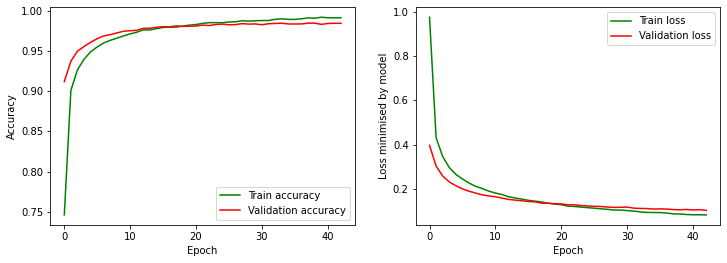

In [ ]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

###11. Reconstructing the best performing model encountered during training (based on validation score)


In [ ]:
#We will now reconstruct the best model encountered during training. This was saved by the ModelCheckpoint. 
#Since we told it to 'save_best_only', it has saved model weights each time an improvement occurred. 
#Our best model is therefore the last of the saved checkpoints.
import pathlib

# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)
checkpoints

/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0038.ckpt


[PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0032.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0017.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0020.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0023.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0019.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0001.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/cp-0002.ckpt'),
 PosixPath('/content

In [ ]:
# Now restore the model
best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below should give slightly better results than that for the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))


Training set Accuracy: 0.9983
Training set Loss:0.066550

Validation set Accuracy: 0.9850
Validation set Loss:0.106973



###12. Final model and analysis

Here, we re-train it on the full original training set (i.e., including the validation set) and use the number of EPOCHS that corresponds to our best validation score in the previous runs (which is 38). Once this re-training has been done, we analyse how our network performs on the test set.

In [ ]:
model_for_test = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 512
epochs = 38

history_for_test = model_for_test.fit(x_train_all, r_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                5130      
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/38
118/118 [==============================] - 1s 5ms/step - loss: 1.4206 - accuracy: 0.6107
Epoch 2/3

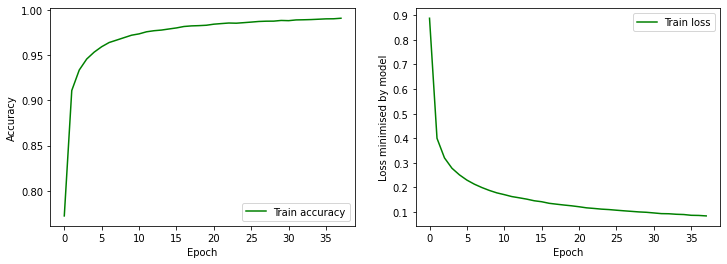

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Now, we will save the whole model, i.e., both the network structure and the weights, because that makes it easier to analyse it in a separate notebook.

In [ ]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"final_model.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model_for_test.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/UGentDL2021/Graded Assignments/002-First Graded Assignment/Checkpoints/final_model.h5


### 13. Measure the performance of your final model on the test set

In [ ]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model_for_test.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(x_test, r_test, verbose=0)
print("Test set Accuracy:{:7.4f}".format(test_accuracy))
print("Test set Loss:{:7.6f}\n".format(test_loss))

Training set Accuracy: 0.9981
Training set Loss:0.063660

Test set Accuracy: 0.9837
Test set Loss:0.102870



### 14. Further analysis on the test set

1.   Misclassification
2.   Confusion Matrix



Now the predictions are carried out on test set and analysed for misclassified samples.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

predictions = model_for_test.predict(x_test)
# final_model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Models/final_model/Checkpoints/final_model.h5')

# the predictions are class probabilities, 
# the argmax code line below finds the index of the class with the highest probability

test_predicted_class = np.argmax(predictions,axis=1)
misclassified = np.where(test_predicted_class!=r_test_class)[0]


There are  163  misclassified samples in the test set.


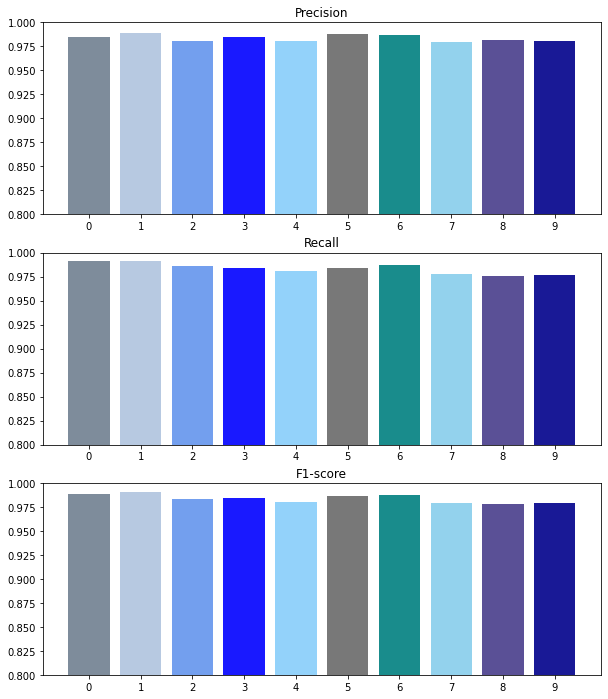

precision: [0.98480243 0.98944591 0.98073218 0.9851338  0.98065173 0.98762655
 0.98644421 0.97953216 0.98140496 0.98109453]
recall: [0.99183673 0.99118943 0.98643411 0.98415842 0.98065173 0.98430493
 0.9874739  0.97762646 0.97535934 0.97720515]
fscore: [0.98830707 0.9903169  0.98357488 0.98464586 0.98065173 0.98596294
 0.98695879 0.97857838 0.97837281 0.97914598]


In [ ]:

# misclassified is a vector that contains the indices of all misclassified samples

print("There are ",misclassified.shape[0]," misclassified samples in the test set.")


precision, recall, f1, _ = score(r_test_class, test_predicted_class)

names = ['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(10,12))
my_colors = 'rgbkymc'  #red, green, blue, black, etc.
plt.subplot(3,1,1)
plt.bar(names, precision,  color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'blue', 'lightskyblue', 'dimgrey', 'teal', 'skyblue', 'darkslateblue', 'darkblue'], alpha=0.9)

plt.ylim([0.8,1])
plt.title("Precision")

plt.subplot(3,1,2)
plt.bar(names, recall, color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'blue', 'lightskyblue', 'dimgrey', 'teal', 'skyblue', 'darkslateblue', 'darkblue'], alpha=0.9)
plt.title("Recall")


plt.ylim([0.8,1])
plt.subplot(3,1,3)
plt.bar(names, f1, color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'blue', 'lightskyblue', 'dimgrey', 'teal', 'skyblue', 'darkslateblue', 'darkblue'], alpha=0.9)

plt.ylim([0.8,1])
plt.title("F1-score")
plt.show()

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(f1))

The first 9 misclassified samples look like this:


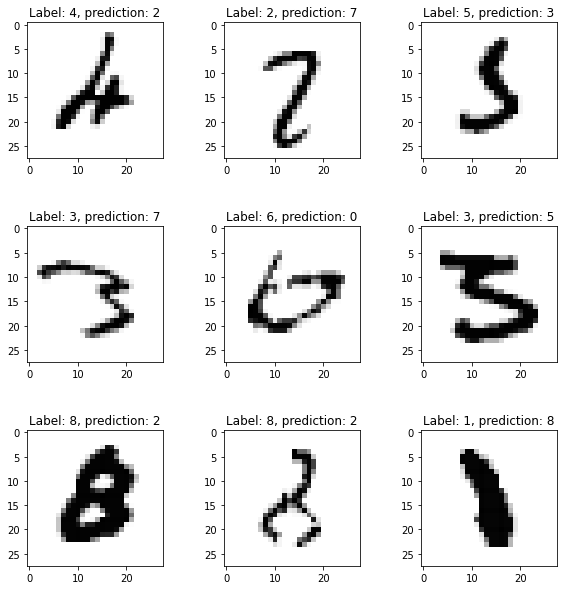

In [ ]:

print("The first 9 misclassified samples look like this:")
f = plt.figure(figsize=(10,10));
for idx in range(9):
    mis_index = misclassified[idx]
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label: " + str(r_test_class[mis_index]) 
              + ", prediction: " + str(test_predicted_class[mis_index]))
    plt.imshow(np.reshape(x_test[mis_index,:],(28,28)), cmap='Greys', interpolation='None')

In [ ]:
# the functions below have been borrowed/adapted from the notebook:
# https://www.tensorflow.org/tutorials/keras/classification

from PIL import Image

# this function plots the image with some annotations
def plot_image(predictions, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions),
                                true_label),
                                color=color)


# this function shows the predictions for this sample
def plot_value_array(predictions, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

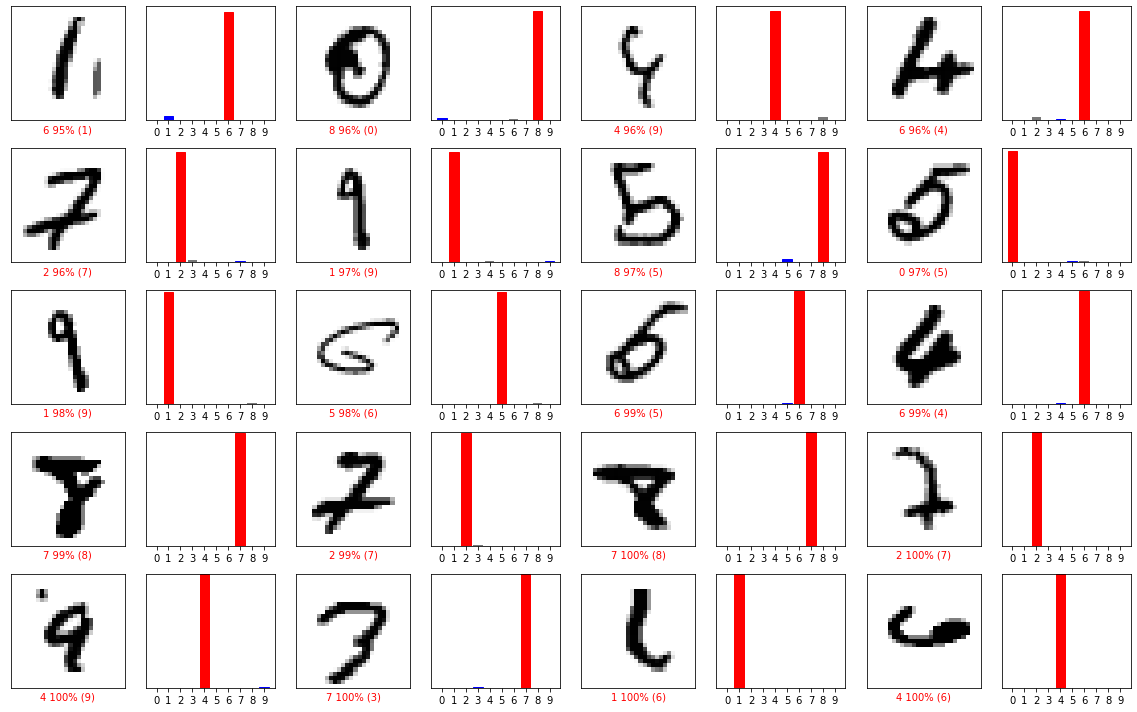

In [ ]:
# probabilities for class that will be predicted
maxprob = np.max(predictions, axis=1)

# find 20 most certain misclassified samples
most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-20:]]

# now we visualise the samples we found

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  idx=most_certain[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[idx], r_test_class[idx], np.reshape(x_test[idx],(28,28)))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[idx], r_test_class[idx])
plt.tight_layout()
plt.show()

2. Confusion Matrices

In [ ]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [ ]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


Confusion matrix, without normalization


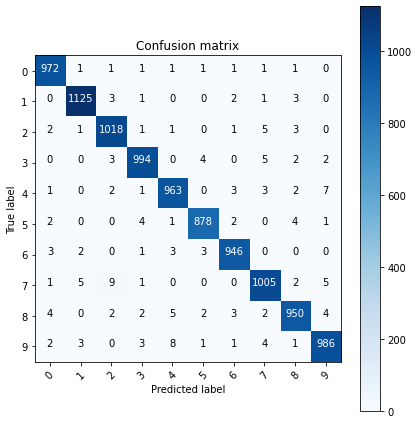

In [ ]:
# An unnormalised confusion matrix shows the numbers of samples in each combination of true class/predicted class

plot_confusion_matrix(r_test_class, test_predicted_class)

Normalized confusion matrix


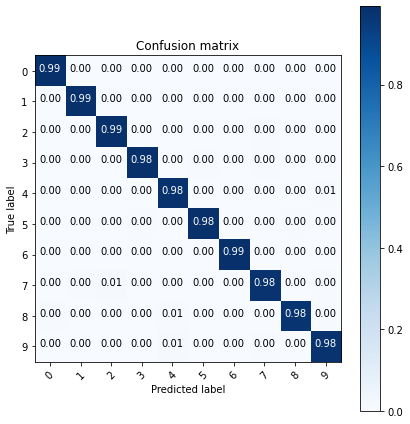

In [ ]:
# A normalised confusion matrix shows for each true class, which fraction of its samples is predicted in each class
# since off-diagonal numbers are hopefully small, this is sometimes less informative

# for perfectly balances tasks, both should give the same information
# for (strongly) unbalanced tasks, they give complementary views

plot_confusion_matrix(r_test_class, test_predicted_class, normalize=True)